# Extract Safran Data


In [9]:
# Magic
%load_ext autoreload
%autoreload 2

# Imports

from tqdm import tqdm

import netCDF4 as nc
import rasterio
import xarray as xr
import re

import pandas as pd
import glob
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
import chime
import datetime as datetime
from datetime import datetime

chime.theme("mario")

# Import Functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from gee_data_wrangling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 👉 User Input


In [2]:
# Set timescale of extraction
my_timescale = "year"  # dayofyear, year, etc.
# If all sites should be re-extracted
force_rerunning_all_sites = False
# Set whether subset of coords should be used
subset_of_coors = False
n_subset = 10

In [11]:
# Give list of ncfiles
dir_safran = "../../data/raw/safran/"
ffolder = sorted(glob.glob(dir_safran + "*.nc"))

# Remove path from folder
ffolder_noprefix = sorted([os.path.basename(x) for x in ffolder])

if len(ffolder) == 0:
    print(f"❌ No files found in folder '{dir_safran}'! Is the hard drive connected?")
    execute_extraction = False
else:
    print(f"✅ {len(ffolder)} files found in folder {dir_safran}")
    print("Datasets available for extraction:")
    for i, f in enumerate(ffolder):
        print(f" {i+1}.\t{f}")
    execute_extraction = True

❌ No files found in folder '../../data/raw/safran/'! Is the hard drive connected?


## Load NFI Sites


In [7]:
# Load latest coordinates for nfi sites
site_coordinates = get_final_nfi_coordinates("noisy", "csv")

# Get subset of sites if desired
if subset_of_coors:
    site_coordinates = site_coordinates.sample(n_subset, random_state=42)

# Get a random set of sites to highlight
random_sites = site_coordinates.sample(9, random_state=42)["SiteID"]
print(f"Shape of site_coordinates: {site_coordinates.shape}")
df_sites = site_coordinates[["idp", "first_year", "x", "y"]]
df_sites.head(3)

Loading noisy coordinates from csv.
Shape of site_coordinates: (41296, 7)


,idp,first_year,x,y
0,500008,2010,6.069031,48.050171
1,500013,2010,1.132647,49.200153
2,500098,2010,4.700861,44.180056


In [8]:
# Test extraction function
# safran_extract_data_per_site(
#     df_sites[:50],
#     ffolder[0],
#     my_timescale,
#     verbose=True,
# )

## Loop over all files


In [6]:
# Note: Multiprocessing is not faster, likely due to RAM limitations when opening large netcdf files.

In [12]:
# Function to extract year from filename


def extract_year_from_filename(filename):
    """
    Extracts the year from the filename based on a specific pattern.

    Args:
    filename (str): The filename to extract the year from.

    Returns:
    int: The extracted year or None if no year is found.
    """
    # Regex pattern to find four consecutive digits before '_fromSAFRAN.nc'
    pattern = r"(\d{4})_fromSAFRAN\.nc$"

    # Search for the pattern in the filename
    match = re.search(pattern, filename)

    # Extract and return the year if found
    if match:
        return int(match.group(1))
    else:
        return None


# Test function
filename = "../../data/raw/safran/ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc"
year = extract_year_from_filename(filename)
print(f"Extracted year: {year}")

Extracted year: 2000


In [27]:
if execute_extraction:
    for my_file in tqdm(ffolder):
        # Get year and bounds
        year = extract_year_from_filename(my_file)
        year_upper = year + 5
        year_lower = year - 5

        # Skip files that are not within the desired range
        # Earliest that I need is 2005, latest 2021
        if year < 2005 or year > 2021:
            print(
                f"Skipping file for year {year} as it is not within the desired range"
            )
            continue

        # Set filename
        my_dir = f"safran_extraction/{my_timescale}"
        my_filepath = f"year_{year}.feather"

        # Skip if file already exists
        if os.path.isfile(f"{my_dir}/{my_filepath}"):
            print(f"Skipping file for year {year} as it already exists")
            continue

        print(
            f"Extracting data for year {year}: for sites falling between {year_lower} - {year_upper}"
        )

        # Filter where sites falls within boundary
        my_sites = df_sites.query(
            "first_year >= @year_lower and first_year <= @year_upper"
        )

        # Extract data
        df_ext = safran_extract_data_per_site(
            my_sites,
            my_file,
            my_timescale,
            verbose=False,
        )
        # Save to file
        os.makedirs(my_dir, exist_ok=True)
        df_ext.to_feather(f"{my_dir}/{my_filepath}")
else:
    print(f"No data was extracted because no files were found in {dir_safran}.")

No data was extracted because no files were found in ../../data/raw/safran/.


## Merge data together


In [31]:
# List all files in my_dir
my_dir = f"safran_extraction/{my_timescale}"
files = sorted(glob.glob(my_dir + "/*.feather"))
files

['safran_extraction/year/year_2005.feather',
 'safran_extraction/year/year_2006.feather',
 'safran_extraction/year/year_2007.feather',
 'safran_extraction/year/year_2008.feather',
 'safran_extraction/year/year_2009.feather',
 'safran_extraction/year/year_2010.feather',
 'safran_extraction/year/year_2011.feather',
 'safran_extraction/year/year_2012.feather',
 'safran_extraction/year/year_2013.feather',
 'safran_extraction/year/year_2014.feather',
 'safran_extraction/year/year_2015.feather',
 'safran_extraction/year/year_2016.feather',
 'safran_extraction/year/year_2017.feather',
 'safran_extraction/year/year_2018.feather',
 'safran_extraction/year/year_2019.feather',
 'safran_extraction/year/year_2020.feather',
 'safran_extraction/year/year_2021.feather']

In [73]:
# Load each file and merge by idp and year
df_list = []
for f in files:
    df = pd.read_feather(f)
    df_list.append(df)
df_all = pd.concat(df_list)

# Attach information on first census year per idp
df_all = df_all.merge(
    df_sites[["idp", "first_year"]].drop_duplicates(),
    on="idp",
    how="left",
)

df_all.insert(0, "first_year", df_all.pop("first_year"))
df_all.insert(0, "idp", df_all.pop("idp"))

# ! DEBUG:
# My first extraction did not filter for sites outside the desired range (fixed now)
# So, here I have to remove rows where year is not within +-5 years of first_year
df_all = df_all.query("year > first_year - 5 and year <= first_year + 5")
# Check if worked -> looks good!
display(df_all.query("idp == 632691"))

# Check
if df_all.shape[0] == df_sites.shape[0] * 10:
    print("✅ All sites were extracted successfully!")
    print(f"Shape of merged dataset: {df_all.shape}")
else:
    print(
        "❌ The number of rows in df_all is not equal to the number of sites times 10!"
    )
    print(f"Shape of merged dataset: {df_all.shape}")
    print(f"Number of sites: {df_sites.shape[0]}")

df_all

,idp,first_year,year,Tair_mean,VPD_mean,SWdown_mean,LWdown_mean,PSurf_mean,Wind_mean,Tair_min,PSurf_min,Tair_max,VPD_max,PSurf_max,Wind_max,Precip_sum
82592,632691,2011,2007,283.912872,6283.933105,136.507782,333.926666,98797.320312,3.380292,267.752319,98790.257812,300.446808,7658.211426,98790.257812,12.150010,0.274772
123888,632691,2011,2008,283.541412,6294.834961,133.409576,329.932343,98797.367188,3.228265,269.438812,98790.257812,299.646088,8009.723145,98790.257812,11.301009,0.301143
165184,632691,2011,2009,283.594360,6275.545410,127.175613,335.007202,98797.320312,3.173202,267.012329,98790.257812,301.045227,8273.914062,98790.257812,12.271010,0.276702
206480,632691,2011,2010,282.850922,6275.122559,133.707520,327.499329,98797.320312,3.081549,268.235229,98790.257812,300.716858,8313.899414,98790.257812,9.813310,0.248391
247776,632691,2011,2011,284.562653,6358.971680,134.702271,332.315765,98797.320312,2.965170,271.410828,98790.257812,303.468933,8203.941406,98790.257812,11.284310,0.186996
289072,632691,2011,2012,283.603271,6308.132324,127.400459,326.626282,98797.367188,3.128869,264.938416,98790.257812,303.467834,8064.824219,98790.257812,11.781010,0.266024
330368,632691,2011,2013,283.401184,6294.843262,128.149399,328.247437,98797.320312,3.227752,269.709747,98790.257812,304.154236,8242.787109,98790.257812,12.600309,0.255366
371664,632691,2011,2014,284.482178,6346.958984,130.359711,334.754547,98797.320312,3.096039,271.107788,98790.257812,300.988190,7826.555664,98790.257812,13.401010,0.326611
412960,632691,2011,2015,284.294464,6343.841309,128.614563,332.926331,98797.320312,3.210650,272.009247,98790.257812,304.838165,8284.490234,98790.257812,10.491009,0.203420
454256,632691,2011,2016,283.917633,6322.156738,117.205139,331.530243,98797.367188,2.930942,269.286682,98790.257812,306.664734,8627.435547,98790.257812,12.163010,0.213900


✅ All sites were extracted successfully!
Shape of merged dataset: (412960, 16)


,idp,first_year,year,Tair_mean,VPD_mean,SWdown_mean,LWdown_mean,PSurf_mean,Wind_mean,Tair_min,PSurf_min,Tair_max,VPD_max,PSurf_max,Wind_max,Precip_sum
41555,500013,2010,2006,284.909119,6395.842285,118.070908,345.993774,1.006759e+05,3.333091,266.872192,1.006834e+05,308.260010,9168.997070,1.006834e+05,13.982800,0.190605
41556,500103,2010,2006,283.569763,6358.666504,136.521378,316.956757,9.810819e+04,3.040078,262.948212,9.810262e+04,307.406433,8708.156250,9.810262e+04,12.882891,0.228568
41557,500192,2010,2006,283.120117,6356.884277,164.813705,322.420624,9.286401e+04,2.478492,265.137085,9.286427e+04,305.241089,8588.029297,9.286427e+04,8.619431,0.346060
41558,500269,2010,2006,NaN,NaN,NaN,NaN,inf,NaN,NaN,9.969210e+36,NaN,NaN,9.969210e+36,NaN,0.000000
41559,500271,2010,2006,286.302246,6457.449707,141.377396,348.891449,1.003713e+05,1.903483,267.441315,1.003819e+05,309.834930,8706.939453,1.003819e+05,10.278010,0.279097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702027,1126336,2016,2021,280.443329,6491.742676,12.402932,357.134399,1.006351e+05,2.645783,278.744690,1.006351e+05,282.595276,6650.916992,1.006351e+05,3.237677,0.000778
702028,1127399,2016,2021,272.292633,5627.406250,21.757097,306.924652,9.849338e+04,1.152647,270.814301,9.849338e+04,274.698425,5862.043945,9.849338e+04,1.647197,0.000042
702029,1128653,2016,2021,275.142212,5950.732422,62.063618,310.983276,9.608613e+04,2.101586,272.735748,9.608613e+04,279.684631,6387.703613,9.608613e+04,3.197473,0.000067
702030,1130588,2016,2021,272.997528,5702.396973,17.989996,321.309906,9.987704e+04,3.023177,272.447601,9.987704e+04,274.121643,5780.125488,9.987704e+04,3.270947,0.000041


In [82]:
# For every site, I need to split the data into years before and after the first census year
# Then I need to calculate different statistics for each year
# Then I need to merge the data back together

# Extract variables that need to be aggregated
vars = df_all.drop(["idp", "year", "first_year"], axis=1).columns

# Calculate statistics for each year
stats = ["mean", "std", "min", "max"]

# Get aggregation metric so that each variable is aggregated by each statistic
my_agg = {}
for v in vars:
    my_agg[v] = stats

# Split data into before and after first census year
df_all_before = df_all.query("year <= first_year")
df_all_after = df_all.query("year > first_year")

# Group data by idp and aggregate
df_all_before = df_all_before.groupby("idp").agg(my_agg)
df_all_after = df_all_after.groupby("idp").agg(my_agg)

# Flatten index
df_all_before.columns = ["_".join(col) for col in df_all_before.columns]
df_all_after.columns = ["_".join(col) for col in df_all_after.columns]

# Reset index
df_all_before = df_all_before.reset_index()
df_all_after = df_all_after.reset_index()

# Remove idp and year before adding suffix to rest
idp_vector = df_all_before["idp"]
df_all_before = df_all_before.drop("idp", axis=1)
df_all_after = df_all_after.drop("idp", axis=1)

# Add suffix to columns
df_all_before = df_all_before.add_suffix("_over_tmin5")
df_all_after = df_all_after.add_suffix("_over_tpls5")

# Add idp back again
df_all_before.insert(0, "idp", idp_vector)
df_all_after.insert(0, "idp", idp_vector)

# Merge data back together
df_merged = pd.merge(df_all_before, df_all_after, on="idp")
df_merged

,idp,Tair_mean_mean_over_tmin5,Tair_mean_std_over_tmin5,Tair_mean_min_over_tmin5,Tair_mean_max_over_tmin5,VPD_mean_mean_over_tmin5,VPD_mean_std_over_tmin5,VPD_mean_min_over_tmin5,VPD_mean_max_over_tmin5,SWdown_mean_mean_over_tmin5,...,PSurf_max_min_over_tpls5,PSurf_max_max_over_tpls5,Wind_max_mean_over_tpls5,Wind_max_std_over_tpls5,Wind_max_min_over_tpls5,Wind_max_max_over_tpls5,Precip_sum_mean_over_tpls5,Precip_sum_std_over_tpls5,Precip_sum_min_over_tpls5,Precip_sum_max_over_tpls5
0,500002,283.350635,0.608669,282.341949,283.942352,6374.643457,37.137456,6318.216797,6420.332031,127.301884,...,97901.781250,97901.781250,9.243777,1.700654,7.512510,11.642843,0.197338,0.030476,0.155269,0.234696
1,500008,283.073663,0.430504,282.363373,283.405273,6317.801367,15.128391,6302.474609,6338.344727,129.717986,...,97430.601562,97430.601562,11.487824,1.521705,9.559939,13.608080,0.269160,0.049287,0.219597,0.347227
2,500012,283.457745,0.587146,282.528717,283.974060,6348.650293,20.026403,6319.030273,6365.151367,126.418130,...,98909.195312,98909.195312,12.871141,1.550996,11.462669,15.063344,0.204083,0.033417,0.170417,0.254467
3,500013,284.355017,0.572335,283.439941,284.909119,6402.758496,8.143001,6395.842285,6416.245605,121.299771,...,100683.406250,100683.406250,13.104084,1.949330,10.940590,15.888800,0.192753,0.029653,0.156677,0.225941
4,500027,282.880884,0.618000,282.302612,283.768280,6359.491797,35.671980,6321.445801,6410.614746,142.383862,...,92187.835938,92187.835938,11.563314,0.849419,10.570849,12.726677,0.583486,0.108872,0.461351,0.719598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41291,1131409,280.288409,0.352455,279.749084,280.638855,6282.834863,24.930103,6249.498047,6309.975586,196.010965,...,86235.257812,86235.257812,11.417151,4.781300,3.314863,15.381473,0.286230,0.173517,0.000000,0.456043
41292,1131410,284.643073,0.663194,283.867798,285.357117,6471.413770,60.124838,6411.954590,6553.037598,123.231679,...,98825.921875,98825.921875,9.488593,4.752519,1.155657,12.438009,0.139979,0.079985,0.000000,0.199565
41293,1131419,285.020361,0.440922,284.566925,285.611328,6380.305957,31.120895,6344.886719,6413.008301,99.696109,...,100949.328125,100949.328125,11.376138,5.482196,1.644130,14.841889,0.211177,0.120847,0.000204,0.293180
41294,1131424,280.632001,0.651540,279.677826,281.349030,6232.074414,56.668445,6152.890137,6309.889648,140.922827,...,89007.234375,89007.234375,12.200042,5.763397,1.981770,15.811250,0.198752,0.114883,0.000000,0.291710


## Save final data


In [83]:
# Save it
df_merged.to_feather(here("data/final/predictor_datasets/safran.feather"))
# Read and check
pd.read_feather(here("data/final/predictor_datasets/safran.feather"))

,idp,Tair_mean_mean_over_tmin5,Tair_mean_std_over_tmin5,Tair_mean_min_over_tmin5,Tair_mean_max_over_tmin5,VPD_mean_mean_over_tmin5,VPD_mean_std_over_tmin5,VPD_mean_min_over_tmin5,VPD_mean_max_over_tmin5,SWdown_mean_mean_over_tmin5,...,PSurf_max_min_over_tpls5,PSurf_max_max_over_tpls5,Wind_max_mean_over_tpls5,Wind_max_std_over_tpls5,Wind_max_min_over_tpls5,Wind_max_max_over_tpls5,Precip_sum_mean_over_tpls5,Precip_sum_std_over_tpls5,Precip_sum_min_over_tpls5,Precip_sum_max_over_tpls5
0,500002,283.350635,0.608669,282.341949,283.942352,6374.643457,37.137456,6318.216797,6420.332031,127.301884,...,97901.781250,97901.781250,9.243777,1.700654,7.512510,11.642843,0.197338,0.030476,0.155269,0.234696
1,500008,283.073663,0.430504,282.363373,283.405273,6317.801367,15.128391,6302.474609,6338.344727,129.717986,...,97430.601562,97430.601562,11.487824,1.521705,9.559939,13.608080,0.269160,0.049287,0.219597,0.347227
2,500012,283.457745,0.587146,282.528717,283.974060,6348.650293,20.026403,6319.030273,6365.151367,126.418130,...,98909.195312,98909.195312,12.871141,1.550996,11.462669,15.063344,0.204083,0.033417,0.170417,0.254467
3,500013,284.355017,0.572335,283.439941,284.909119,6402.758496,8.143001,6395.842285,6416.245605,121.299771,...,100683.406250,100683.406250,13.104084,1.949330,10.940590,15.888800,0.192753,0.029653,0.156677,0.225941
4,500027,282.880884,0.618000,282.302612,283.768280,6359.491797,35.671980,6321.445801,6410.614746,142.383862,...,92187.835938,92187.835938,11.563314,0.849419,10.570849,12.726677,0.583486,0.108872,0.461351,0.719598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41291,1131409,280.288409,0.352455,279.749084,280.638855,6282.834863,24.930103,6249.498047,6309.975586,196.010965,...,86235.257812,86235.257812,11.417151,4.781300,3.314863,15.381473,0.286230,0.173517,0.000000,0.456043
41292,1131410,284.643073,0.663194,283.867798,285.357117,6471.413770,60.124838,6411.954590,6553.037598,123.231679,...,98825.921875,98825.921875,9.488593,4.752519,1.155657,12.438009,0.139979,0.079985,0.000000,0.199565
41293,1131419,285.020361,0.440922,284.566925,285.611328,6380.305957,31.120895,6344.886719,6413.008301,99.696109,...,100949.328125,100949.328125,11.376138,5.482196,1.644130,14.841889,0.211177,0.120847,0.000204,0.293180
41294,1131424,280.632001,0.651540,279.677826,281.349030,6232.074414,56.668445,6152.890137,6309.889648,140.922827,...,89007.234375,89007.234375,12.200042,5.763397,1.981770,15.811250,0.198752,0.114883,0.000000,0.291710


---

## Different NetCDF Tests


### Check CRS


In [199]:
# Open the NetCDF file
ds = xr.open_dataset(ffolder[0])

# Initial assumption: no projection information found
projection_info_found = False

# Check global attributes for projection info
for attr in ds.attrs:
    if "crs" in attr or "grid_mapping" in attr or "projection" in attr:
        print("Global projection information:", ds.attrs[attr])
        projection_info_found = True
        break

# If not found in global attributes, check in variables
if not projection_info_found:
    for var in ds.data_vars:
        for attr in ds[var].attrs:
            if "crs" in attr or "grid_mapping" in attr or "projection" in attr:
                print(
                    f"Projection information in variable '{var}':", ds[var].attrs[attr]
                )
                projection_info_found = True
                break
        if projection_info_found:
            break

if not projection_info_found:
    print("No projection information found in the dataset.")

Projection information in variable 'Qair': Lambert_conformal


### Extract closest raster value


280.3518981933594

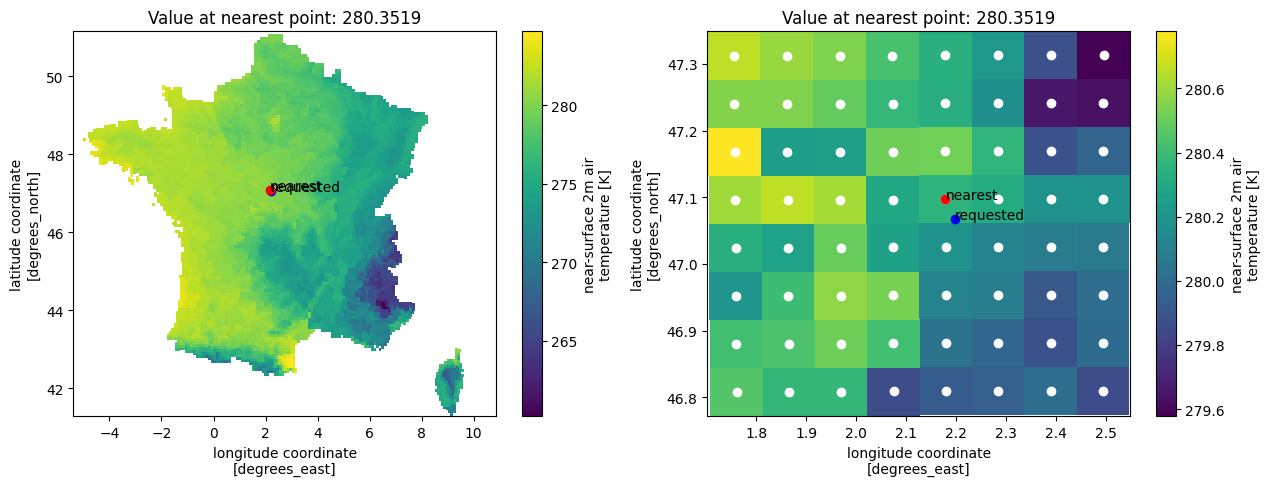

In [3]:
safran_extract_value(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
    return_fig=True,
)

In [4]:
safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0])["SWdown"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
)

(77, 66)

In [5]:
plat, plon = safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0]),
    lat_in=47.067897,
    lon_in=2.197266,
)

safran_extract_from_index(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    latloc=plat,
    lonloc=plon,
)

280.3518981933594

In [21]:
# Extract the date im form YYYYMMDD from np.datetime64
np.datetime64("2019-01-01T00:00:00.000000000").astype("datetime64[ns]").astype(str)

'2019-01-01T00:00:00.000000000'

In [48]:
ds_test = xr.open_dataset(ffolder[0])
ds_test

<xarray.Dataset>
Dimensions:  (tstep: 8784, lat: 134, lon: 143)
Coordinates:
    lat      (lat, lon) float32 ...
    lon      (lat, lon) float32 ...
  * tstep    (tstep) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
Data variables:
    Qair     (tstep, lat, lon) float32 ...
    Tair     (tstep, lat, lon) float32 ...
    Wind     (tstep, lat, lon) float32 ...
    Rainf    (tstep, lat, lon) float64 ...
    Snowf    (tstep, lat, lon) float64 ...
    SWdown   (tstep, lat, lon) float32 ...
    LWdown   (tstep, lat, lon) float32 ...
    PSurf    (tstep, lat, lon) float32 ...
Attributes:
    history:                    Sat Sep 10 23:33:30 2022: ncks -v tstep Times...
    history_of_appended_files:  Sat Sep 10 23:33:30 2022: Appended file Times...
    NCO:                        "4.6.3"

### Creation of New Variables


In [165]:
pd.DataFrame().empty

True

#### Precipitation


In [137]:
# Open file
ds_test = xr.open_dataset(ffolder[0])
# Precip is sum of rain and snow
ds_test["Precip"] = ds_test["Rainf"] + ds_test["Snowf"]
# Take annual mean
tmp = ds_test[["Precip", "Snowf", "Rainf"]].groupby("tstep.year").mean("tstep")

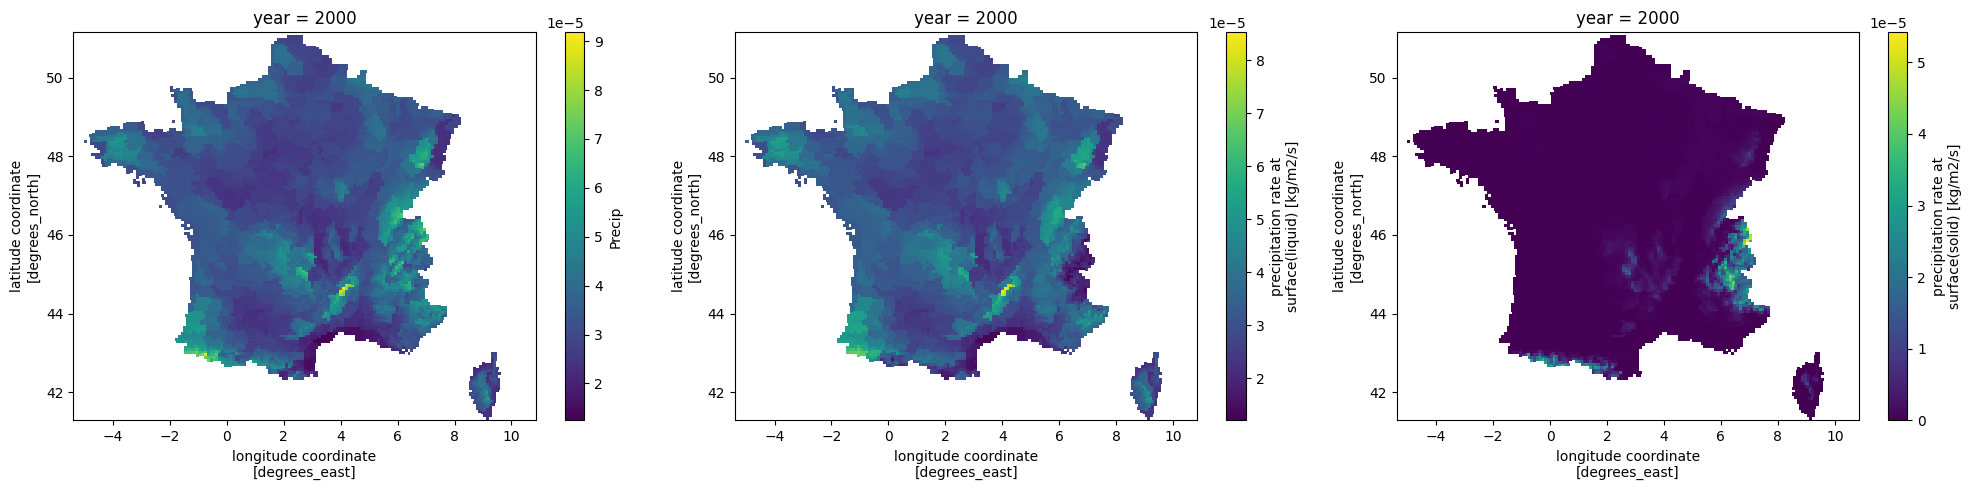

In [138]:
# Plot it
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
tmp["Precip"][0, :, :].plot(ax=ax[0])
tmp["Rainf"][0, :, :].plot(ax=ax[1])
tmp["Snowf"][0, :, :].plot(ax=ax[2])
fig.tight_layout()

#### VPD

1. **Saturation Vapor Pressure (SVP):**
   The SVP is estimated using the Tetens formula, which is a function of air temperature (T):

   $$
   SVP = 0.6108 \times e^{\frac{17.27 \times T}{T + 237.3}}
   $$

   where T is the air temperature in degrees Celsius.

2. **Actual Vapor Pressure (AVP):**
   AVP is derived from specific humidity (Qair) and surface pressure (PSurf):

   $$
   AVP = \frac{Qair \times PSurf}{0.622 + 0.378 \times Qair}
   $$

   where Qair is specific humidity (in kg/kg) and PSurf is surface pressure (in Pa).

3. **VPD Calculation:**
   VPD is the difference between SVP and AVP:
   $$
   VPD = SVP - AVP
   $$


In [131]:
# Open file
ds_test = xr.open_dataset(ffolder[0])
# Calculate variables
ds_test["SVP"] = 0.6108 * np.exp((17.27 * ds_test["Tair"]) / (ds_test["Tair"] + 237.3))
ds_test["AVP"] = (ds_test["Qair"] * ds_test["PSurf"]) / (
    0.622 + 0.378 * ds_test["Qair"]
)
ds_test["VPD"] = ds_test["SVP"] - ds_test["AVP"]
# Take annual mean
tmp = ds_test[["Tair", "Qair", "VPD"]].groupby("tstep.year").mean("tstep")

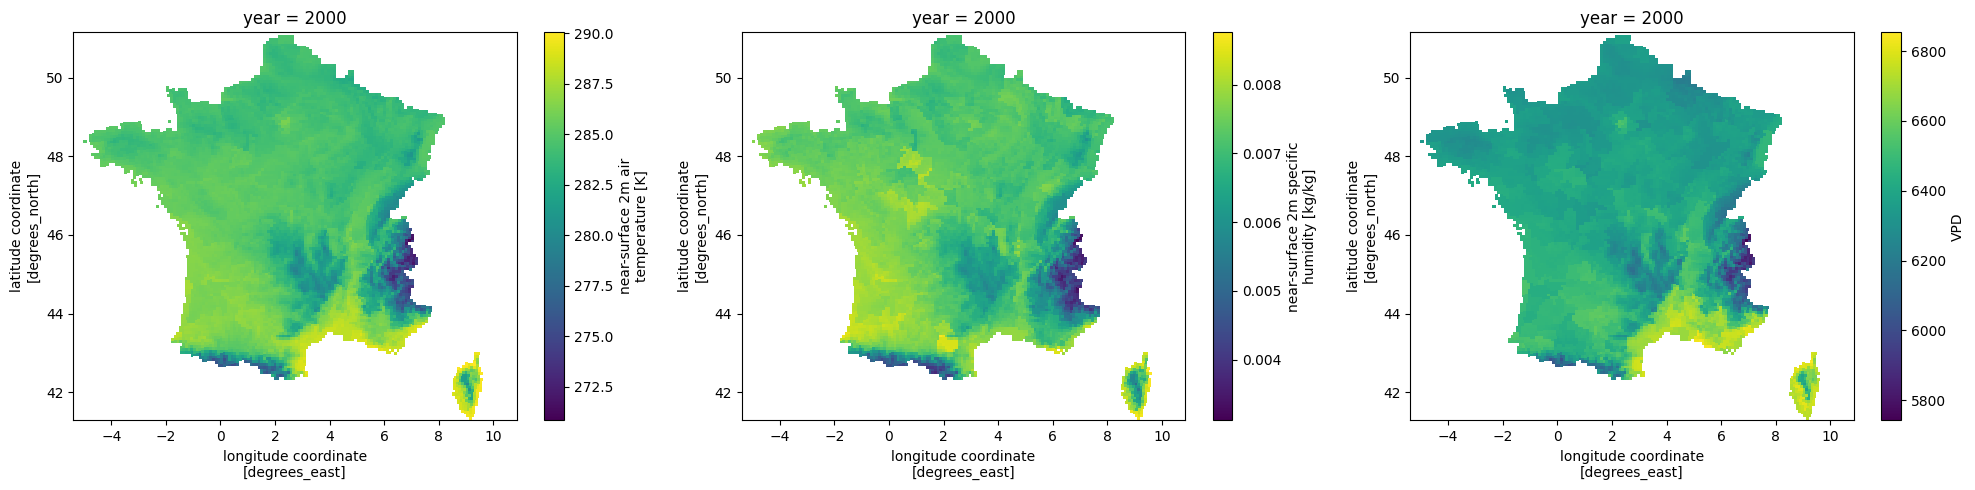

In [135]:
# Plot it
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
tmp["Tair"][0, :, :].plot(ax=ax[0])
tmp["Qair"][0, :, :].plot(ax=ax[1])
tmp["VPD"][0, :, :].plot(ax=ax[2])

fig.tight_layout()

### Other tests


CPU times: user 838 ms, sys: 529 ms, total: 1.37 s
Wall time: 3.53 s


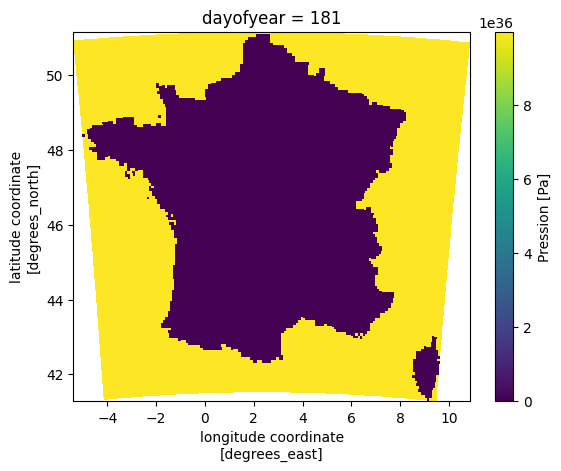

In [105]:
%%time
# Testing how long it takes to take mean for subset of variables
ds_test = xr.open_dataset(ffolder[0]))
ds_test = ds_test["PSurf"].groupby("tstep.dayofyear").mean("tstep")
display(ds_test[180, :, :].plot())

CPU times: user 1.74 s, sys: 1.41 s, total: 3.15 s
Wall time: 7.84 s


/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


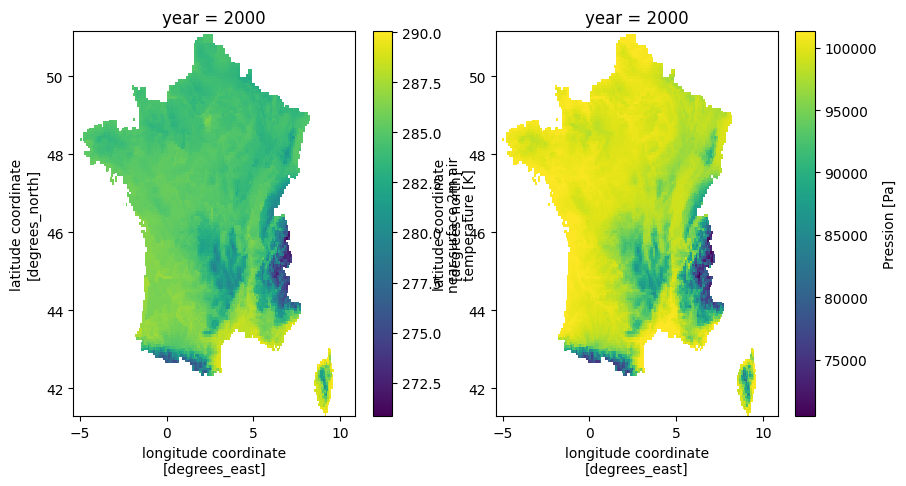

In [101]:
%%time
# Testing how long it takes to take mean for subset of variables
ds_test = xr.open_dataset(ffolder[0])
ds_test = ds_test[["Tair", "PSurf"]].groupby("tstep.year").mean("tstep")
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ds_test["Tair"][0, :, :].plot(ax=ax[0])
ds_test["PSurf"][0, :, :].plot(ax=ax[1])

In [65]:
# Reduce the values in ds_test to the mean of...
# ... Day: Reducing to dayofyear takes ~40 seconds (was doing two mps when testing, so probably faster)
# ... Year: Reducing to year takes ~50 seconds
ds_test = xr.open_dataset(ffolder[0])  # Takes almost no time
ds_test = ds_test.groupby("tstep.year").mean("tstep")
ds_test

KeyboardInterrupt: 

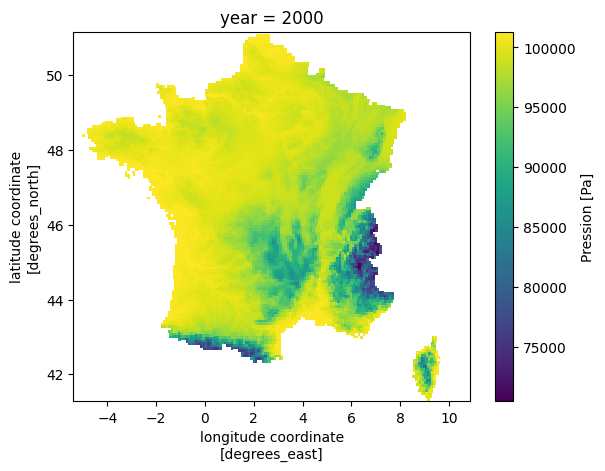

In [56]:
ds_test["PSurf"][0, :, :].plot()  # When aggregated to year
# ds_test["Tair"][180, :, :].plot()  # When aggregated to daily

## Testing Extraction Functions


In [167]:
# safran_extract_from_index(ds_test["Tair"][180, :, :], plat, plon) # When aggregated to daily
safran_extract_from_index(
    ds_test["Tair"][0, :, :], plat, plon
)  # When aggregated to yearly

280.3518981933594

In [169]:
# Cell only to quickly change ds_test for cell below
ds_test = xr.open_dataset(ffolder[0])
ds_test = ds_test["Tair"].groupby("tstep.dayofyear").mean("tstep")

In [172]:
from utilities import safran_extract_all_timesteps

safran_extract_all_timesteps(
    ds_var=ds_test,
    my_var="Tair_mean",
    time_var="dayofyear",
    latloc=plat,
    lonloc=plon,
    verbose=True,
)

# Notes:
# Extraction on annual level takes ~31.5 ms
# Extraction on daily level takes ~116 ms

        - Working on timestep (dayofyear): 100%|██████████| 366/366 [00:00<00:00, 2711.21it/s]


,dayofyear,Tair_mean
0,1,280.704895
0,2,279.187531
0,3,277.745697
0,4,280.583405
0,5,281.844147
...,...,...
0,362,281.452179
0,363,277.169159
0,364,275.606232
0,365,274.117584


---


In [87]:
# Running daily mean extraction

# Extract everything before the first underscore

current_vars = requested_variables.split("_", 1)[0]
current_vars

NameError: name 'requested_variables' is not defined

In [64]:
df_list[0]
ffolder[0]

'../../data/raw/safran/ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc'

In [94]:
df_sites

,idp,first_year,x,y
14224,1031155,2015,5.123290,48.949017
14399,1104466,2016,5.780498,47.743949
2299,711269,2012,5.488906,47.329123
6650,537195,2010,4.131339,47.897959
21027,641084,2011,0.301426,43.161639
...,...,...,...,...
10840,825676,2013,0.832516,48.207857
3434,827113,2013,-3.030482,48.058722
19511,608245,2011,6.389746,44.364497
36491,1028177,2015,-1.326894,44.045121


In [108]:
pd.concat(df_list[0:10])

,idp,first_year,x,y
15953,511221,2010,0.378553,47.391500
16758,529369,2010,-3.204581,47.924399
16875,531969,2010,4.491439,43.932553
16908,532505,2010,0.235032,42.962644
6646,537010,2010,3.461656,49.111062
6650,537195,2010,4.131339,47.897959
6914,551990,2010,0.565286,43.364049
17837,553695,2010,2.232118,47.947665
18067,559534,2010,1.980784,45.518231
967,559912,2010,6.717543,47.451216


In [110]:
# Option 1:
# - Parallelise by file: Open one file, loop over all sites to extract data -> Potentially very slow
# - Parallelise by site: Loop over all sites, open same file for each, do for multiple files. -> Calling each file sequentially but should be shorter as one run, so not running for days.

In [114]:
# Group df_sites into 10 equally sized dataframes
df_sites = df_sites.reset_index(drop=True)
df_sites_split = np.array_split(df_sites, 10)
df_sites_split[0]

,idp,first_year,x,y
0,1031155,2015,5.123290,48.949017
1,1104466,2016,5.780498,47.743949
2,711269,2012,5.488906,47.329123
3,537195,2010,4.131339,47.897959
4,641084,2011,0.301426,43.161639
5,864443,2013,3.843856,48.135870
6,603328,2011,7.483729,48.230808
7,826931,2013,4.651948,48.788263
8,644323,2011,4.437055,46.165072
9,679858,2011,3.202085,44.238174


In [121]:
from utilities import safran_extract_data_per_site

df_mp = run_mp(
    safran_extract_data_per_site,
    ffolder,
    num_cores=10,
    progress_bar=True,
    sites_in=df_sites_split[0],
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [11:05<?, ?it/s]05.85s/it]


In [117]:
from utilities import safran_extract_data_per_site

df_mp = run_mp(
    safran_extract_data_per_site,
    df_sites_split,
    num_cores=10,
    progress_bar=True,
    nc_filepath=ffolder[0],
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [06:06<?, ?it/s]7.48s/it]


KeyboardInterrupt: 

In [88]:
from utilities import safran_extract_data_per_site

safran_extract_data_per_site(
    nc_filepath=ffolder[0],
    sites_in=pd.concat(df_list[0:10]),
    only_daily_means=True,
    verbose=False,
)

KeyboardInterrupt: 

❌ Add checks -> Extract hourly for one site and plot all variable. On top, plot the extract max, mean, min to see if it mathces!


---


In [ ]:
# Turn into geodataframe and set crs to 3035
df_sites_org = site_coordinates.copy()[["idp", "first_year", "x_fr", "y_fr"]]
df_sites_org = gpd.GeoDataFrame(
    df_sites_org,
    geometry=gpd.points_from_xy(df_sites_org.x_fr, df_sites_org.y_fr),
    crs="EPSG:4326",
)

# From geodataframe, extract x and y locations
x_filecrs = df_sites_filecrs.geometry.x
y_filecrs = df_sites_filecrs.geometry.y

# Overwrite df_sites again and attach filecrs-based coordinates
df_sites = site_coordinates.copy()[["idp", "first_year"]]
df_sites["x"] = x_filecrs
df_sites["y"] = y_filecrs

# Attach start and end year for each site for easier extraction
df_sites["start_year"] = df_sites.first_year - 5
df_sites["end_year"] = df_sites.first_year + 5

# Print info
print(df_sites.shape)
df_sites.head(3)

In [ ]:
# Create folium map to see if nfi_plots still fall within France
# Get subset to not plot all 40k sites, if not reduced already
if subset_of_coors:
    df_map1 = df_sites_org
    df_map2 = df_sites_filecrs
else:
    df_map1 = df_sites_org.sample(random_state=42, n=1000)
    df_map2 = df_sites_filecrs.sample(random_state=42, n=1000)

# Dataframe to highlight a specific site
df_highlight = df_sites_org.query("idp in @random_sites")

# Make map
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Add original sites to map
folium.GeoJson(
    df_map1,
    name="Original NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="black"),
).add_to(m)

# Add transformed sites to map
folium.GeoJson(
    df_map2,
    name="Transformed NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="red", radius=1),
).add_to(m)

# Add highlighted sites to map
folium.GeoJson(
    df_highlight,
    name="Highlighted NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="blue", radius=5),
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
if subset_of_coors:
    m.save(
        f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites_subset.html"
    )
else:
    m.save(f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites.html")

# Show map
m

# Load all years for all files into one dataframe


In [ ]:
# Run in parallel
df_mp = run_mp(
    parallel_edo_extraction,
    df_list,
    progress_bar=True,
    num_cores=10,
    df_sites=df_sites,
    debug=False,
    expected_crs=file_crs,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [30:40<00:00, 184.03s/it]  


In [ ]:
# Unlist results by concatenating them
df_unlisted = pd.concat(df_mp)

# Clean structure a bit
df_unlisted = df_unlisted.sort_values(["idp", "date"]).reset_index(drop=True)
df_unlisted.insert(0, "idp", df_unlisted.pop("idp"))
df_unlisted.insert(1, "date", df_unlisted.pop("date"))

# Set -9999 to NA
df_unlisted = df_unlisted.replace(-9999, np.nan)

# Attach season information
df_unlisted = match_season_to_month(df_unlisted)

# Attach information whether observation is from before or after first_year
# * Important Assumption: Measurement was done on 31st of August (fall-cut-off)
# Code looks ugly but works
df_unlisted["before_first_year"] = df_unlisted["date"] < (
    df_unlisted["first_year"].astype(str) + "-08-31"
).astype("datetime64[ns]")

# Display it
display(df_unlisted)

,idp,date,mintmp,first_year,x,y,start_year,end_year,season,before_first_year
0,500002,2005-01-01,3.3025,2010,7.378014,48.253411,2005,2015,winter,True
18675033,562918,2005-01-01,3.1995,2010,5.837938,47.805254,2005,2015,winter,True
18671016,562899,2005-01-01,10.7595,2010,-1.980153,47.705838,2005,2015,winter,True
2068755,506900,2005-01-01,5.2200,2010,1.574573,48.988112,2005,2015,winter,True
18666999,562896,2005-01-01,9.2980,2010,0.788900,46.947840,2005,2015,winter,True
...,...,...,...,...,...,...,...,...,...,...
151688025,1117717,2021-12-31,4.5650,2016,6.376465,46.806061,2011,2021,winter,False
151692043,1117727,2021-12-31,-0.0840,2016,5.637757,44.380744,2011,2021,winter,False
151696061,1117750,2021-12-31,5.3890,2016,0.607629,46.864264,2011,2021,winter,False
151704097,1117767,2021-12-31,6.9090,2016,-0.884106,45.913565,2011,2021,winter,False


# Quality Control of Extraction


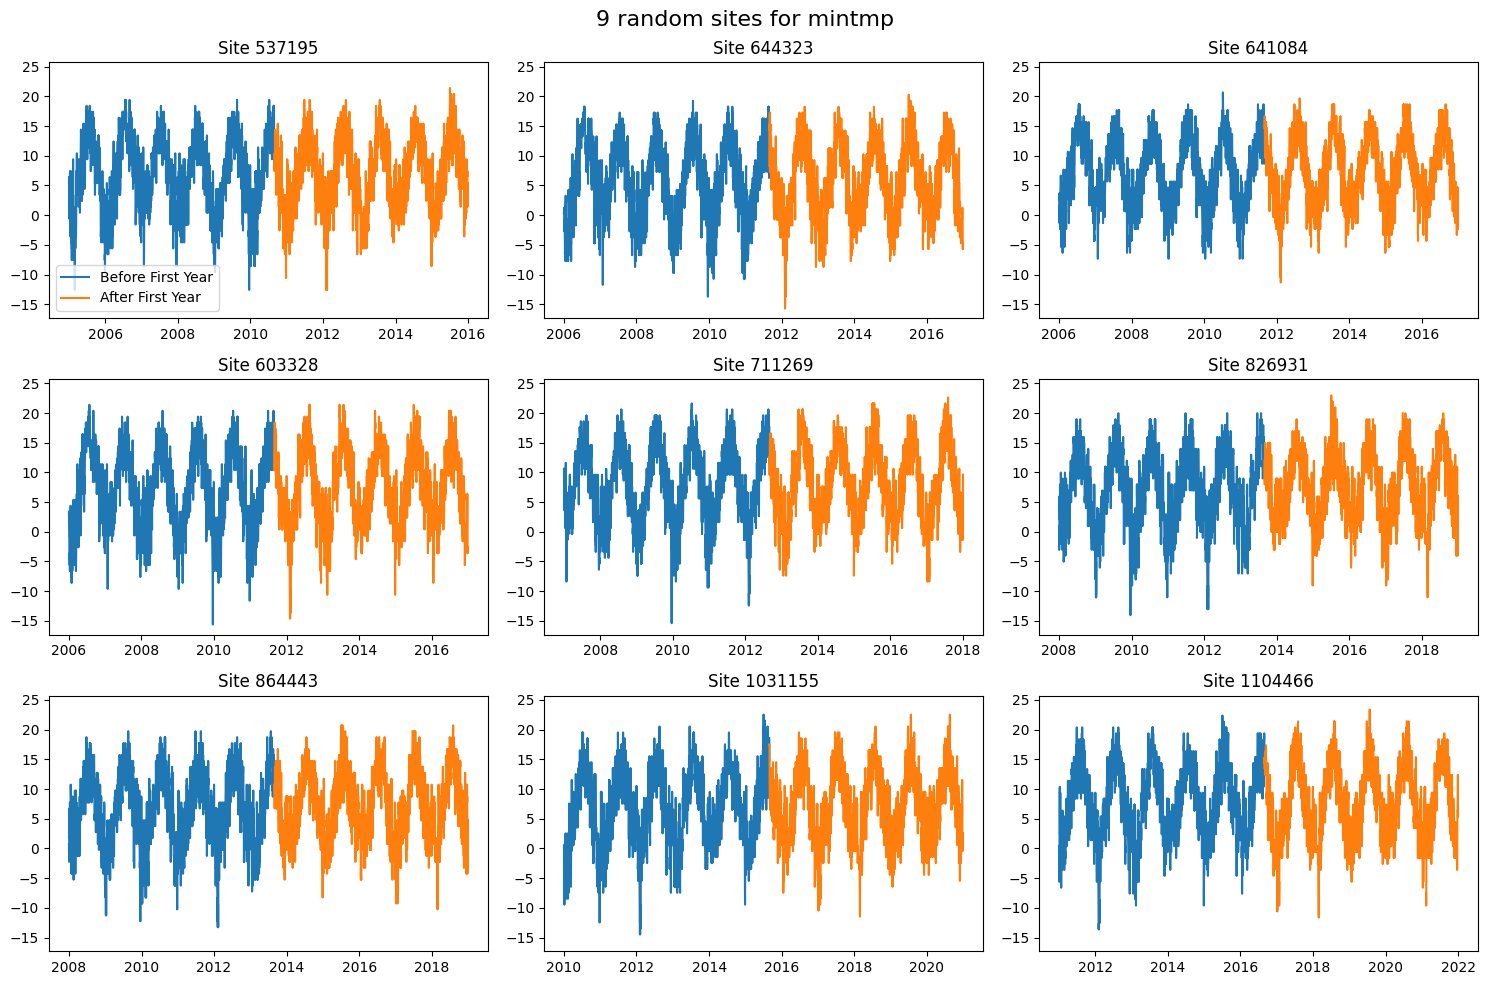

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Add a title to the entire grid
fig.suptitle(f"{len(axes.flatten())} random sites for {subfolder}", fontsize=16)

# Reduce df_unlisted to sites in random_sites
df_red = df_unlisted.query("idp in @random_sites").copy().reset_index(drop=True)

# If heatwave dataset, replace NA by 0 to make plot more readable
if subfolder == "heatw":
    df_red[subfolder] = df_red[subfolder].fillna(0)

# Get minimum and maximum value for y-axis
min_ = df_red[subfolder].min()
max_ = df_red[subfolder].max()

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Reduce df_unlisted to sites in random_sites
    random_site = df_red["idp"].unique()[i]

    # Get subset
    subset = df_red[df_red["idp"] == random_site]

    # Plot subset when before_first_year is true
    ax.plot(
        subset[subset["before_first_year"]]["date"],
        subset[subset["before_first_year"]][subfolder],
        label="Before First Year",
    )

    # Plot subset when before_first_year is false
    ax.plot(
        subset[~subset["before_first_year"]]["date"],
        subset[~subset["before_first_year"]][subfolder],
        label="After First Year",
    )

    ax.set_title(f"Site {random_site}")

    # Set y-axis limits
    ax.set_ylim((min_ + min_ * 0.1), (max_ + max_ * 0.1))

# Add legend to the last subplot
axes.flatten()[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
if subset_of_coors:
    plotname = f"edo_qc_files/{subfolder}_random_sites_subset.png"
else:
    plotname = f"edo_qc_files/{subfolder}_random_sites.png"
plt.savefig(plotname)

# Show the plot
plt.show()

# Save File


In [ ]:
# Save pre-aggregation dataframe
if subset_of_coors:
    savedfeather = f"data_edo_{subfolder}_raw_subset.feather"
else:
    savedfeather = f"data_edo_{subfolder}_raw.feather"

df_unlisted.reset_index(drop=True).to_feather(savedfeather)

print(f"✅ Successfully saved dataframe:\t{savedfeather}\t at {datetime.datetime.now()}")
chime.success()

✅ Successfully saved dataframe:	data_edo_mintmp_raw.feather	 at 2023-12-11 19:29:29.935969
